In [ ]:
!pip install pandas --upgrade 

In [ ]:
!pip install numpy --upgrade

In [ ]:
!pip install matplotlib --upgrade

In [ ]:
!pip install seaborn --upgrade

In [ ]:
!pip install scikit-learn --upgrade

In [ ]:
!pip install tqdm --upgrade

In [ ]:
!pip install peft

In [ ]:
!pip install torch

In [ ]:
!pip install transformers

In [ ]:
!pip install optimum

In [ ]:
!pip install transformers torch

### 1. Identify the task and labeled datset
- Choose a supervised learning task such as text classification, summarization, question answering, or instruction following, preferably within a specific domain (e.g., legal, medical, finance, science, etc.).

- Select a labeled dataset appropriate for your task — one that includes both inputs and target outputs (e.g., prompts and responses, questions and answers, or documents and labels).

- Make sure the dataset is:
* Relevant to your chosen domain and task

* Small enough to fine-tune efficiently (especially with PEFT), but large enough to produce meaningful improvements

* You may need to experiment with dataset size or sampling to find a good balance between training time and performance.

In [1]:
import difflib
import re
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from tqdm import tqdm
import transformers
#import peft
from transformers import AutoModelForCausalLM, AutoTokenizer #, pipeline
#from peft import LoraConfig, get_peft_model
from datasets import load_dataset, Dataset, DatasetDict
import optimum

In [4]:
df = pd.read_csv('dataset.csv')
df.head()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
0,Fungal infection,itching,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Fungal infection,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Fungal infection,itching,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Fungal infection,itching,skin_rash,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Fungal infection,itching,skin_rash,nodal_skin_eruptions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 2. Process Your Data
- Clean and preprocess the dataset to be suitable for an SL.
- Convert the dataset into a format compatible with your training pipeline. 
- Consider preprocessing your data to improve training quality.

In [5]:
df.shape

(4920, 18)

In [5]:
# Clean and standardize symptom columns
symptom_cols = [col for col in df.columns if 'Symptom_' in col]

# Create processed dataframe with only disease and symptoms
processed_df = pd.DataFrame()
processed_df['disease'] = df['Disease']

# Create natural language symptom descriptions directly
processed_df['symptoms'] = df[symptom_cols].apply(
    lambda x: f"Patient presents with: {'; '.join([str(s).replace('_', ' ').strip() for s in x.dropna().tolist()])}", 
    axis=1
)

processed_df = processed_df.drop_duplicates(subset=['disease', 'symptoms'])

In [6]:
processed_df.head()

,disease,symptoms
0,Fungal infection,Patient presents with: itching; skin rash; nod...
1,Fungal infection,Patient presents with: skin rash; nodal skin e...
2,Fungal infection,Patient presents with: itching; nodal skin eru...
3,Fungal infection,Patient presents with: itching; skin rash; dis...
4,Fungal infection,Patient presents with: itching; skin rash; nod...


In [8]:
print(processed_df.isnull().sum())

disease     0
symptoms    0
dtype: int64


In [7]:
# Get unique diseases in the order they first appear in the dataset
unique_diseases = processed_df['disease'].unique()

# Create mapping dictionary preserving original order
label_mapping = {disease: idx for idx, disease in enumerate(unique_diseases)}

# Add the numeric labels to processed_df
processed_df['label'] = processed_df['disease'].map(label_mapping)

# Create reverse mapping
idx_to_disease = {idx: disease for disease, idx in label_mapping.items()}

# Print the mapping to verify
print("Label mapping examples:")
for i, (disease, idx) in enumerate(label_mapping.items()):
    if i < 42:  # Print the first 10 
        print(f"{idx}: {disease}")

print(f"\nTotal diseases mapped: {len(label_mapping)}")

# Verify the mapping was applied correctly
print("\nSample data with labels:")
print(processed_df[['disease', 'symptoms', 'label']].head())

Label mapping examples:
0: Fungal infection
1: Allergy
2: GERD
3: Chronic cholestasis
4: Drug Reaction
5: Peptic ulcer diseae
6: AIDS
7: Diabetes 
8: Gastroenteritis
9: Bronchial Asthma
10: Hypertension 
11: Migraine
12: Cervical spondylosis
13: Paralysis (brain hemorrhage)
14: Jaundice
15: Malaria
16: Chicken pox
17: Dengue
18: Typhoid
19: hepatitis A
20: Hepatitis B
21: Hepatitis C
22: Hepatitis D
23: Hepatitis E
24: Alcoholic hepatitis
25: Tuberculosis
26: Common Cold
27: Pneumonia
28: Dimorphic hemmorhoids(piles)
29: Heart attack
30: Varicose veins
31: Hypothyroidism
32: Hyperthyroidism
33: Hypoglycemia
34: Osteoarthristis
35: Arthritis
36: (vertigo) Paroymsal  Positional Vertigo
37: Acne
38: Urinary tract infection
39: Psoriasis
40: Impetigo

Total diseases mapped: 41

Sample data with labels:
            disease                                           symptoms  label
0  Fungal infection  Patient presents with: itching; skin rash; nod...      0
1  Fungal infection  Patient prese

In [8]:
# Split into train and evaluation sets (80/20 split)
train_df, val_df = train_test_split(
    processed_df, 
    test_size=0.2, 
    random_state=42,
    stratify=processed_df['disease']  # Ensure class balance
)

print(f"Training samples: {len(train_df)}")
print(f"Evaluation samples: {len(val_df)}")

Training samples: 243
Evaluation samples: 61


# Define Prompt Format

In [9]:
def build_improved_prompt(symptoms):
    """Build a simpler, more direct prompt for the OPT model"""
    symptoms_text = symptoms.replace("Patient presents with: ", "")
    
    prompt = f"""Given these symptoms: {symptoms_text}
    
The disease is:"""
    
    return prompt

# Load Model and Tokenizer

In [9]:
!pip install numpy==1.24.3 --force-reinstall

  Using cached numpy-1.24.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
Using cached numpy-1.24.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autogluon-multimodal 1.2 requires nvidia-ml-py3==7.352.0, which is not installed.
autogluon-common 1.2 requires numpy<2.1.4,>=1.25.0, but you have numpy 1.24.3 which is incompatible.
autogluon-core 1.2 requires numpy<2.1.4,>=1.25.0, but you have numpy 1.24.3 which is incompatible.
autogluon-core 1.2 requires scikit-learn<1.5.3,>=1.4.0, but you have scikit-learn 1.6.1 which is incompatible.
autogluon-features 1.2 requires numpy<2.1.4,>=1.25.0, but you have numpy 1.24.3 w

In [10]:
# Define model name
model_name = "facebook/opt-1.3b"

# Load tokenizer
print("Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(model_name)

if model_name == "facebook/opt-1.3b":
    tokenizer.padding_side = 'left'

print("Loading model with GPU-only setup...")
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="cuda",  # Use available GPUs
    torch_dtype=torch.float16  # Use half precision to save memory
)

print("Model loaded successfully!")

Loading tokenizer...
Loading model with GPU-only setup...


2025-04-21 22:08:59.456207: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-21 22:08:59.472425: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-21 22:08:59.477551: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-21 22:08:59.489507: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model loaded successfully!


### 3. Baseline Measurement
* Before fine-tuning, evaluate the performance of a pretrained autoregressive language model on your supervised task.

* Use your labeled dataset in its original input-output format (e.g., prompt → response, input → label).

* Measure how well the model performs without fine-tuning, using metrics appropriate for your task:

* Accuracy, F1-score for classification

* BLEU, ROUGE, or exact match for generation or QA


* This will serve as your baseline for comparing performance after PEFT fine-tuning.

In [11]:
def extract_disease_prediction(output, prompt):
    """Extract disease prediction with fuzzy matching capabilities"""
    # Get only the generated text (anything after the prompt)
    response = output[len(prompt):].strip()
    
    # If there's nothing meaningful, return empty string
    if not response or response.isspace():
        return ""
    
    # Try direct matching with any disease name
    for disease in unique_diseases:
        if disease.lower() in response.lower():
            return disease
    
    # Try fuzzy matching for close matches
    best_match = None
    highest_similarity = 0
    
    for disease in unique_diseases:
        # Calculate similarity between response and disease
        similarity = difflib.SequenceMatcher(None, response.lower(), disease.lower()).ratio()
        if similarity > highest_similarity and similarity > 0.7:  # Threshold
            highest_similarity = similarity
            best_match = disease
    
    if best_match:
        return best_match
    
    # Get first sentence if no match
    first_sentence = response.split('.')[0].strip()
    
    words = first_sentence.lower().split()
    for disease in unique_diseases:
        disease_lower = disease.lower()
        for word in words:
            if disease_lower.startswith(word) and len(word) > 3:  # Only meaningful words
                return disease
    
    return ""  # Return empty if no match found

In [12]:
def improved_batch_inference(model, prompts, batch_size=2):
    results = []
    
    for i in tqdm(range(0, len(prompts), batch_size), desc="Running inference"):
        batch = prompts[i:i+batch_size]
        inputs = tokenizer.batch_encode_plus(
            batch, 
            return_tensors="pt", 
            padding=True, 
            max_length=256,
            truncation=True
        ).to("cuda")
        
        with torch.no_grad():
            outputs = model.generate(
                input_ids=inputs["input_ids"],
                attention_mask=inputs["attention_mask"],
                max_new_tokens=100,          # Significantly increased
                num_beams=4,                 # Better beam search
                temperature=0.2,             # Lower temperature for more focused output
                do_sample=False,             # Disable sampling for more deterministic output
                top_p=1.0,                   # Use full distribution
                repetition_penalty=1.5,      # Strongly discourage repetition
                length_penalty=1.0,          # Neutral length penalty
                no_repeat_ngram_size=2,      # Avoid repeating bigrams
                early_stopping=True,         # Stop when complete
                pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id
            )
        
        decoded_outputs = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        
        # Process predictions
        for output, prompt in zip(decoded_outputs, batch):
            prediction = extract_disease_prediction(output, prompt)
            results.append(prediction)
    
    return results

In [13]:
def evaluate_baseline_model():
    # Create improved prompts
    improved_prompts = [build_improved_prompt(symptoms) for symptoms in val_df['symptoms']]
    
    # Print a sample prompt
    print("\nExample improved prompt:")
    print(improved_prompts[0])
    
    # Run inference with improved parameters
    predictions = improved_batch_inference(model, improved_prompts)
    
    # Count valid predictions
    valid_count = sum(1 for p in predictions if p)
    print(f"\nValid predictions: {valid_count} out of {len(predictions)} ({valid_count/len(predictions)*100:.1f}%)")
    
    # Handle empty predictions for accuracy calculation
    filled_predictions = []
    for p in predictions:
        if not p:  # If prediction is empty
            filled_predictions.append("Unknown")  # Default value
        else:
            filled_predictions.append(p)
    
    # Calculate metrics (only on non-empty predictions)
    non_empty_indices = [i for i, p in enumerate(predictions) if p]
    if non_empty_indices:
        filtered_actual = [val_df['disease'].iloc[i] for i in non_empty_indices]
        filtered_pred = [predictions[i] for i in non_empty_indices]
        
        if filtered_pred:  # Only calculate if we have predictions
            accuracy = accuracy_score(filtered_actual, filtered_pred)
            f1 = f1_score(filtered_actual, filtered_pred, average="macro", zero_division=0)
            print(f"\nBaseline Model Accuracy (on valid predictions): {accuracy:.4f}")
            print(f"Baseline Model Macro F1 Score (on valid predictions): {f1:.4f}")
    
    # Sample predictions
    print("\nSample predictions (first 10):")
    print("-" * 60)
    print(f"{'Actual':<30} | {'Predicted':<25} | {'Match'}")
    print("-" * 60)
    
    for i in range(min(10, len(val_df))):
        actual = val_df['disease'].iloc[i]
        pred = predictions[i]
        match = "✓" if actual == pred else "✗"
        print(f"{actual:<30} | {pred:<25} | {match}")
    
    return predictions

# Run the improved evaluation
baseline_predictions = evaluate_baseline_model()


Example improved prompt:
Given these symptoms: itching; fatigue; lethargy; yellowish skin; dark urine; loss of appetite; abdominal pain; yellowing of eyes; malaise; receiving blood transfusion; receiving unsterile injections
    
The disease is:


/opt/conda/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Running inference: 100%|██████████| 31/31 [00:55<00:00,  1.80s/it]


Valid predictions: 35 out of 61 (57.4%)

Baseline Model Accuracy (on valid predictions): 0.2286
Baseline Model Macro F1 Score (on valid predictions): 0.1790

Sample predictions (first 10):
------------------------------------------------------------
Actual                         | Predicted                 | Match
------------------------------------------------------------
Hepatitis B                    |                           | ✗
Pneumonia                      | Hepatitis B               | ✗
Drug Reaction                  | Hepatitis B               | ✗
Allergy                        |                           | ✗
Pneumonia                      | Chronic cholestasis       | ✗
Hypothyroidism                 |                           | ✗
Typhoid                        | Typhoid                   | ✓
Fungal infection               |                           | ✗
Common Cold                    | Hepatitis B               | ✗
Hyperthyroidism                |                      

## Define batch fuction 

### 4. Fine-Tune a AR model using PEFT
* Fine-tune a pretrained autoregressive language model on your domain-specific, labeled dataset using Parameter-Efficient Fine-Tuning (PEFT) with LoRA (Low-Rank Adaptation).

* Use a PEFT framework such as the Hugging Face peft library to integrate LoRA into your training pipeline.

* LoRA modifies only a small subset of the model's parameters, allowing for efficient training even on limited hardware.

* Implement a training loop or use tools like Trainer or accelerate for easier setup.

* After training, save the LoRA adapter weights for reuse or evaluation — you can later merge them with the base model if needed.


In [14]:
import torch
import pandas as pd
import numpy as np
import difflib
from transformers import AutoModelForCausalLM, AutoTokenizer, Trainer, TrainingArguments
from peft import LoraConfig, get_peft_model
from datasets import Dataset
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, classification_report

In [15]:
# Ensure tokenizer is properly configured
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id
    print(f"Pad token set to: {tokenizer.pad_token}")
    print(f"Pad token ID: {tokenizer.pad_token_id}")

In [16]:
# Enable gradient checkpointing to save memory
model.gradient_checkpointing_enable()
model.enable_input_require_grads()

In [17]:
# Prepare training data
train_inputs = []
train_outputs = []
for idx, row in train_df.iterrows():
    train_inputs.append(build_improved_prompt(row['symptoms']))
    train_outputs.append(row['disease'])

# Create dataset
train_dataset = Dataset.from_dict({
    "input_text": train_inputs,
    "output_text": train_outputs
})

In [18]:
# Define tokenization function
def tokenize_function(examples):
    # Create complete sequences with both input and expected output
    complete_texts = []
    for inp, out in zip(examples["input_text"], examples["output_text"]):
        complete_texts.append(inp + out)
    
    # Tokenize complete sequences
    tokenized = tokenizer(
        complete_texts,
        max_length=384,
        padding="max_length",
        truncation=True,
        return_tensors=None
    )
    
    # Create proper labels for causal LM training
    tokenized["labels"] = [
        [token if token != tokenizer.pad_token_id else -100 for token in ids] 
        for ids in tokenized["input_ids"]
    ]
    
    return tokenized

In [19]:
# Apply tokenization
tokenized_train_dataset = train_dataset.map(
    tokenize_function,
    batched=True,
    batch_size=8,
    remove_columns=train_dataset.column_names
)

Parameter 'function'=<function tokenize_function at 0x7f594de1b600> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/31 [00:00<?, ?ba/s]

In [20]:
# Apply LoRA configuration
lora_config = LoraConfig(
    r=16,  # Reduced rank
    lora_alpha=32,  # Adjusted alpha
    target_modules=["q_proj", "v_proj", "k_proj", "o_proj", "up_proj", "down_proj", "gate_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

# Apply LoRA to your existing model
print("Applying LoRA adapters to model...")
model_peft = get_peft_model(model, lora_config)
model_peft.print_trainable_parameters()

Applying LoRA adapters to model...
trainable params: 4,718,592 || all params: 1,320,476,672 || trainable%: 0.3573


In [23]:
training_args = TrainingArguments(
    output_dir="./medical-diagnosis-lora-adapter",
    learning_rate=1e-4,            # Lower learning rate for stability
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    num_train_epochs=30,           # More epochs for better learning
    lr_scheduler_type="cosine",    # Cosine schedule for smoother learning
    gradient_checkpointing=True,
    save_strategy="epoch",
    save_total_limit=3,            # Save only best 3 checkpoints
    fp16=True,
    warmup_ratio=0.1,              # Warmup for more stable training
    weight_decay=0.01,             # Regularization
    remove_unused_columns=False,   # Necessary for proper data handling
    logging_steps=10,
    report_to="tensorboard"        # Monitor training
)

In [24]:
has_grad_params = False
for param in model_peft.parameters():
    if param.requires_grad:
        has_grad_params = True
        break

if not has_grad_params:
    print("Warning: No parameters require gradients! Forcing gradients...")
    model_peft.requires_grad_(True)

In [25]:
trainer = Trainer(
    model=model_peft,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    tokenizer=tokenizer,
)

# Start training
trainer.train()

/tmp/ipykernel_25417/3132038175.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/opt/conda/lib/python3.11/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss
10,3.729800
20,3.586300
30,3.213900
40,2.921400
50,2.306200
60,1.840300
70,1.547700
80,1.506600
90,1.335000
100,1.253100


TrainOutput(global_step=900, training_loss=0.646243682967292, metrics={'train_runtime': 875.476, 'train_samples_per_second': 8.327, 'train_steps_per_second': 1.028, 'total_flos': 1.972219663613952e+16, 'train_loss': 0.646243682967292, 'epoch': 29.032921810699587})

In [26]:
# Save the fine-tuned model and tokenizer
model_peft.save_pretrained("./medical-diagnosis-lora-adapter")
tokenizer.save_pretrained("./medical-diagnosis-lora-adapter")
print("LoRA adapter weights and tokenizer saved successfully!")

LoRA adapter weights and tokenizer saved successfully!


### 5. Remeasure the Fine-Tuned Model
* Evaluate the performance of your fine-tuned autoregressive model (now updated using LoRA) on the same supervised task and dataset used for the baseline.

* Use the same evaluation metric as before (e.g., accuracy, BLEU, ROUGE, or perplexity, depending on the task).

* Compare the results with the baseline measurement to assess the impact of fine-tuning.

* Analyze whether the model has improved in task performance, and consider potential areas for further tuning or data refinement.

In [27]:
# Improved prediction extraction function
def extract_finetuned_prediction(output, prompt):
    """Modified extraction function for fine-tuned model"""
    # Get only the generated text (anything after the prompt)
    response = output[len(prompt):].strip()
    
    # Clean up the response - take first line or sentence
    if '\n' in response:
        response = response.split('\n')[0].strip()
    if '.' in response:
        response = response.split('.')[0].strip()
    
    # Direct matching with disease names
    for disease in unique_diseases:
        if disease.lower() in response.lower():
            return disease
    
    # More aggressive fuzzy matching
    best_match = None
    highest_similarity = 0
    
    for disease in unique_diseases:
        similarity = difflib.SequenceMatcher(None, response.lower(), disease.lower()).ratio()
        if similarity > highest_similarity and similarity > 0.6:  # Lower threshold
            highest_similarity = similarity
            best_match = disease
    
    if best_match:
        return best_match
    
    return ""  # Return empty if no match found

In [28]:
# Improved inference function for the fine-tuned model
def finetuned_batch_inference(model, prompts, batch_size=2):
    results = []
    
    for i in tqdm(range(0, len(prompts), batch_size), desc="Running inference"):
        batch = prompts[i:i+batch_size]
        inputs = tokenizer.batch_encode_plus(
            batch, 
            return_tensors="pt", 
            padding=True, 
            max_length=256,
            truncation=True
        ).to("cuda")
        
        with torch.no_grad():
            outputs = model.generate(
                input_ids=inputs["input_ids"],
                attention_mask=inputs["attention_mask"],
                max_new_tokens=20,          # Shorter for disease names
                num_beams=5,                # More beams for better accuracy
                temperature=0.7,            # Higher temperature for more diversity
                do_sample=True,             # Enable sampling
                top_p=0.95,                 # Top-p sampling
                repetition_penalty=1.2,     # Lighter repetition penalty
                length_penalty=1.0,
                early_stopping=True,
                pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id
            )
        
        decoded_outputs = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        
        # Process predictions with the modified extraction
        for output, prompt in zip(decoded_outputs, batch):
            prediction = extract_finetuned_prediction(output, prompt)
            results.append(prediction)
    
    return results

In [29]:
# Load the fine-tuned model properly
from peft import PeftModel, PeftConfig

# Load the configuration
peft_config = PeftConfig.from_pretrained("./medical-diagnosis-lora-adapter")

# Load a fresh base model
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,  # Make sure this is the same model used during training
    device_map="cuda",
    torch_dtype=torch.float16
)

# Load the LoRA adapter onto the fresh base model
model_finetuned = PeftModel.from_pretrained(
    base_model,
    "./medical-diagnosis-lora-adapter",
    torch_dtype=torch.float16
)

# Set to evaluation mode
model_finetuned.eval()
print("Fine-tuned model loaded successfully!")

Fine-tuned model loaded successfully!


In [30]:
# Create validation prompts with the improved prompt function
val_prompts = [build_improved_prompt(symptoms) for symptoms in val_df['symptoms']]

# Run inference with fine-tuned model
print("Running inference with fine-tuned model...")
finetuned_predictions = finetuned_batch_inference(model_finetuned, val_prompts)

# Calculate metrics
accuracy = accuracy_score(val_df['disease'], finetuned_predictions)
f1 = f1_score(
    val_df['disease'], 
    finetuned_predictions,
    average="macro",
    zero_division=0
)

# Print simple results
print(f"Fine-tuned Model Accuracy: {accuracy:.4f}")
print(f"Fine-tuned Model Macro F1 Score: {f1:.4f}")

# Generate classification report
print("\nClassification Report for Fine-tuned Model:")
print(classification_report(
    val_df['disease'], 
    finetuned_predictions,
    zero_division=0
))

Running inference with fine-tuned model...


Running inference: 100%|██████████| 31/31 [00:17<00:00,  1.74it/s]

Fine-tuned Model Accuracy: 0.9016
Fine-tuned Model Macro F1 Score: 0.8764

Classification Report for Fine-tuned Model:
                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       0.00      0.00      0.00         1
                                   AIDS       0.00      0.00      0.00         1
                                   Acne       1.00      1.00      1.00         1
                    Alcoholic hepatitis       0.00      0.00      0.00         2
                                Allergy       1.00      1.00      1.00         1
                              Arthritis       1.00      1.00      1.00         1
                       Bronchial Asthma       0.50      1.00      0.67         1
                   Cervical spondylosis       1.00      1.00      1.00         1
                            Chicken pox       1.00      1.00      1.00         2
                    Chronic cholestasis       1.00      0.50      0.67

### 7. Organize & Summarize Results
- Present your results in a structured format.
- Compare the performance of the pre-trained and fine-tuned models.
- Discuss key takeaways from the fine-tuning process.

In [31]:
if 'baseline_predictions' in globals():
    # Count valid predictions
    valid_baseline = [p for p in baseline_predictions if p]
    valid_finetuned = [p for p in finetuned_predictions if p]
    
    print(f"\nComparison Summary:")
    print(f"Baseline valid predictions: {len(valid_baseline)}/{len(baseline_predictions)} ({len(valid_baseline)/len(baseline_predictions)*100:.1f}%)")
    print(f"Fine-tuned valid predictions: {len(valid_finetuned)}/{len(finetuned_predictions)} ({len(valid_finetuned)/len(finetuned_predictions)*100:.1f}%)")
    
    # Print side-by-side sample comparison
    print("\nSample Comparison (first 10):")
    print("-" * 80)
    print(f"{'Actual':<25} | {'Baseline':<25} | {'Fine-tuned':<25}")
    print("-" * 80)
    
    for i in range(min(10, len(val_df))):
        actual = val_df['disease'].iloc[i]
        baseline = baseline_predictions[i] if i < len(baseline_predictions) else ""
        finetuned = finetuned_predictions[i] if i < len(finetuned_predictions) else ""
        
        print(f"{actual:<25} | {baseline:<25} | {finetuned:<25}")


Comparison Summary:
Baseline valid predictions: 35/61 (57.4%)
Fine-tuned valid predictions: 61/61 (100.0%)

Sample Comparison (first 10):
--------------------------------------------------------------------------------
Actual                    | Baseline                  | Fine-tuned               
--------------------------------------------------------------------------------
Hepatitis B               |                           | Hepatitis B              
Pneumonia                 | Hepatitis B               | Pneumonia                
Drug Reaction             | Hepatitis B               | Drug Reaction            
Allergy                   |                           | Allergy                  
Pneumonia                 | Chronic cholestasis       | Pneumonia                
Hypothyroidism            |                           | Hypothyroidism           
Typhoid                   | Typhoid                   | Typhoid                  
Fungal infection          |                

In [32]:
import gradio as gr
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel
import difflib

# Load the model (same code we used for evaluation)
model_name = "facebook/opt-1.3b"
tokenizer = AutoTokenizer.from_pretrained("./medical-diagnosis-lora-adapter")
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="cuda",
    torch_dtype=torch.float16
)
model = PeftModel.from_pretrained(
    base_model,
    "./medical-diagnosis-lora-adapter",
    torch_dtype=torch.float16
)
model.eval()

# Load diseases list
unique_diseases = [
    "Fungal infection", "Allergy", "GERD", "Chronic cholestasis", "Drug Reaction",
    "Peptic ulcer diseae", "AIDS", "Diabetes", "Gastroenteritis", "Bronchial Asthma",
    "Hypertension", "Migraine", "Cervical spondylosis", "Paralysis (brain hemorrhage)",
    "Jaundice", "Malaria", "Chicken pox", "Dengue", "Typhoid", "hepatitis A",
    "Hepatitis B", "Hepatitis C", "Hepatitis D", "Hepatitis E", "Alcoholic hepatitis",
    "Tuberculosis", "Common Cold", "Pneumonia", "Dimorphic hemmorhoids(piles)",
    "Heart attack", "Varicose veins", "Hypothyroidism", "Hyperthyroidism", "Hypoglycemia",
    "Osteoarthristis", "Arthritis", "(vertigo) Paroymsal Positional Vertigo",
    "Acne", "Urinary tract infection", "Psoriasis", "Impetigo"
]

def build_prompt(symptoms_text):
    # Format the symptoms into the expected prompt format
    return f"Given these symptoms: {symptoms_text}\n\nThe disease is:"

def predict_disease(symptoms_text):
    # Build prompt
    prompt = build_prompt(symptoms_text)
    
    # Tokenize the input
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    
    # Generate prediction
    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_new_tokens=20,
            num_beams=5,
            temperature=0.7,
            do_sample=True,
            top_p=0.95,
            repetition_penalty=1.2,
            early_stopping=True
        )
    
    # Decode the output
    predicted_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    # Extract the disease name using the same function as in evaluation
    response = predicted_text[len(prompt):].strip()
    
    # Clean up the response
    if '\n' in response:
        response = response.split('\n')[0].strip()
    if '.' in response:
        response = response.split('.')[0].strip()
    
    # Direct matching
    for disease in unique_diseases:
        if disease.lower() in response.lower():
            return disease, response
    
    # Fuzzy matching
    best_match = None
    highest_similarity = 0
    
    for disease in unique_diseases:
        similarity = difflib.SequenceMatcher(None, response.lower(), disease.lower()).ratio()
        if similarity > highest_similarity and similarity > 0.6:
            highest_similarity = similarity
            best_match = disease
    
    if best_match:
        return best_match, response
    
    return "No specific disease detected", response

# Create the Gradio interface
def gradio_interface(symptoms):
    disease, raw_output = predict_disease(symptoms)
    confidence = "High" if disease in unique_diseases else "Low"
    return disease, confidence, raw_output

# Create the demo
demo = gr.Interface(
    fn=gradio_interface,
    inputs=gr.Textbox(lines=5, placeholder="Enter symptoms separated by semicolons (e.g., itching; skin rash; high fever)"),
    outputs=[
        gr.Textbox(label="Predicted Disease"),
        gr.Textbox(label="Confidence"),
        gr.Textbox(label="Raw Model Output")
    ],
    title="Medical Diagnosis Assistant",
    description="Enter patient symptoms to get a potential diagnosis. This is a demo and should not replace professional medical advice.",
    theme="huggingface",
    examples=[
        ["itching; skin rash; nodal skin eruptions"],
        ["continuous sneezing; shivering; chills; watering from eyes"],
        ["stomach pain; acidity; ulcers on tongue; vomiting; cough; chest pain"]
    ]
)

demo.launch(share=True) 

/opt/conda/lib/python3.11/site-packages/gradio/blocks.py:1114: UserWarning: Cannot load huggingface. Caught Exception: 404 Client Error: Not Found for url: https://huggingface.co/api/spaces/huggingface (Request ID: Root=1-6806c7f4-766ea0ce059c837748a65486;ecf7f744-0f98-4208-a56a-ec91e13c4953)

Sorry, we can't find the page you are looking for.
  warnings.warn(f"Cannot load {theme}. Caught Exception: {str(e)}")


* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://4e06b369783c073109.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [36]:
# For already trained model
train_subsets = []
subset_sizes = [0.2, 0.4, 0.6, 0.8, 1.0]  # Different fractions of training data

for i, size in enumerate(subset_sizes):
    # Sample a subset of the training data
    n_samples = int(len(train_df) * size)
    train_subset = train_df.sample(n_samples, random_state=42)
    
    # Evaluate on this subset and validation data
    train_preds = evaluate_dataset(model_finetuned, tokenizer, train_subset)
    train_acc = accuracy_score(train_subset['disease'], train_preds)
    train_accuracies.append(train_acc)
    
    val_preds = evaluate_dataset(model_finetuned, tokenizer, val_df)
    val_acc = accuracy_score(val_df['disease'], val_preds)
    val_accuracies.append(val_acc)
    
    print(f"Subset {i+1} ({size*100:.0f}% of data): Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

# Create a learning curve based on dataset size
plt.figure(figsize=(10, 6))
plt.plot([s*len(train_df) for s in subset_sizes], train_accuracies, 'b-o', label='Training Accuracy')
plt.plot([s*len(train_df) for s in subset_sizes], val_accuracies, 'r-o', label='Validation Accuracy')
plt.title('Learning Curve by Dataset Size')
plt.xlabel('Number of Training Examples')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('learning_curve_by_size.png')
plt.show()

Subset 1 (20% of data): Train Acc: 0.8750, Val Acc: 0.8361


Subset 2 (40% of data): Train Acc: 0.8969, Val Acc: 0.8525


Subset 3 (60% of data): Train Acc: 0.8828, Val Acc: 0.8361


Subset 4 (80% of data): Train Acc: 0.8866, Val Acc: 0.8361


Subset 5 (100% of data): Train Acc: 0.8807, Val Acc: 0.8361


<Figure size 1000x600 with 1 Axes>

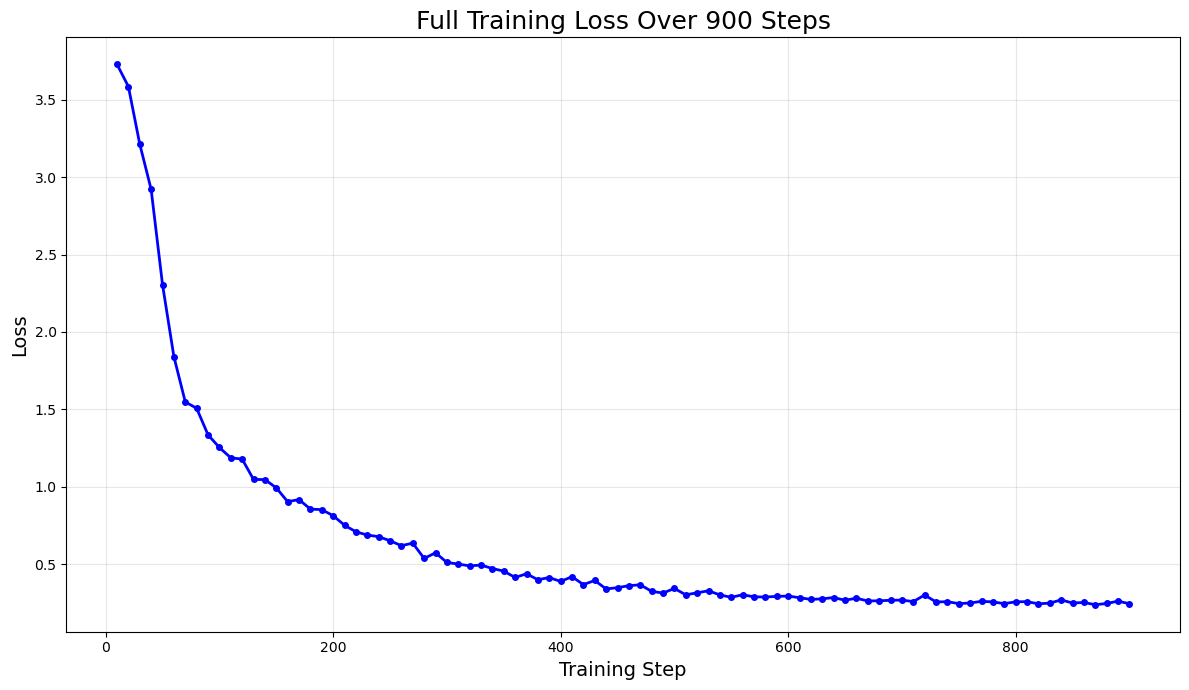

In [70]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Training loss values from step 10 to 900
steps = list(range(10, 910, 10))  # Steps from 10 to 900 in increments of 10

# Loss values
losses = [3.729800, 3.586300, 3.213900, 2.921400, 2.306200, 1.840300, 1.547700, 1.506600, 1.335000, 
          1.253100, 1.186300, 1.178300, 1.046600, 1.045800, 0.992400, 0.903000, 0.916500, 0.854800, 
          0.851500, 0.812300, 0.750700, 0.708300, 0.687300, 0.676700, 0.650400, 0.618400, 0.635000, 
          0.535700, 0.572600, 0.510100, 0.499600, 0.488000, 0.493100, 0.470800, 0.454000, 0.412800, 
          0.437000, 0.398300, 0.412500, 0.387300, 0.418100, 0.366900, 0.393500, 0.338600, 0.347100, 
          0.359900, 0.365600, 0.323200, 0.312300, 0.341900, 0.300900, 0.313800, 0.326900, 0.300100, 
          0.284800, 0.301200, 0.287700, 0.286600, 0.290700, 0.292900, 0.282100, 0.271100, 0.274900, 
          0.283200, 0.265800, 0.279000, 0.261100, 0.262200, 0.265400, 0.266900, 0.256900, 0.299500, 
          0.254800, 0.256300, 0.244000, 0.247800, 0.258800, 0.255000, 0.243800, 0.255500, 0.256700, 
          0.242600, 0.247100, 0.268000, 0.247900, 0.251200, 0.236900, 0.244700, 0.260000, 0.243200]

# Create the plot
plt.figure(figsize=(12, 7))

# Create main plot
plt.plot(steps, losses, 'b-', linewidth=2, marker='o', markersize=4)



# Main plot formatting
plt.title('Full Training Loss Over 900 Steps', fontsize=18)
plt.xlabel('Training Step', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.grid(True, alpha=0.3)



# Add a detailed view of the later training stages

plt.tight_layout()
plt.savefig('full_training_loss_curve.png', dpi=300)
plt.show()

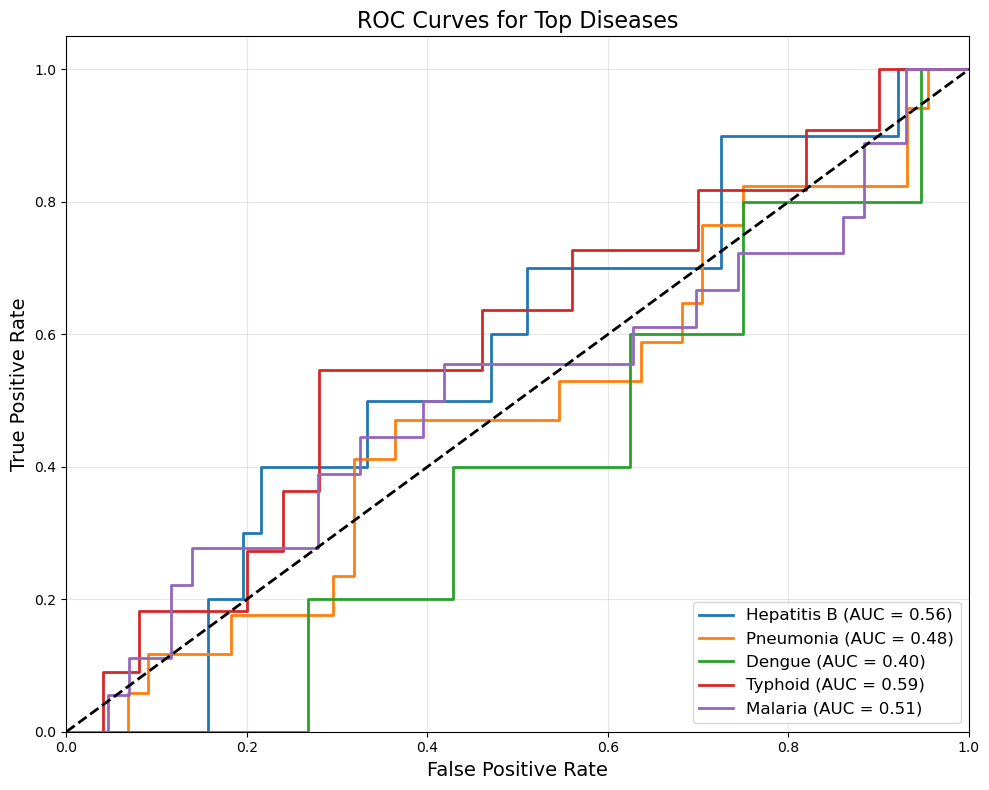

In [62]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
%matplotlib inline

# This is a simplified example for a few diseases
# You'll need to adapt this with your actual model prediction probabilities

# Create sample data - in reality, you would use your model's actual probabilities
# Assuming we're looking at 5 common diseases in your dataset
diseases = ['Hepatitis B', 'Pneumonia', 'Dengue', 'Typhoid', 'Malaria']
n_diseases = len(diseases)

# Sample size
n_samples = 61  # Your validation set size

# Create mock probability data - replace with your actual model probabilities
# This would normally come from model.predict_proba() or similar
np.random.seed(42)  # For reproducibility
y_score = np.random.rand(n_samples, n_diseases)  # Random probabilities between 0-1

# Create mock true labels (one-hot encoded)
# In reality, this would be your actual ground truth labels
y_true = np.zeros((n_samples, n_diseases))
for i in range(n_samples):
    true_class = np.random.randint(0, n_diseases)  # Random class for this example
    y_true[i, true_class] = 1

# Compute ROC curve and ROC area for each disease
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10, 8))

for i in range(n_diseases):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot ROC curves
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'{diseases[i]} (AUC = {roc_auc[i]:.2f})')

# Plot diagonal
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Set plot details
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curves for Top Diseases', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('roc_curve.png')
plt.show()